# Klein model
> Does the Klein model allow us to circumvent the hyperboloid modifications to decision trees?

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import anndata

from src.hyperdt.tree import HyperbolicDecisionTreeClassifier
from src.hyperdt.tree import (
    DecisionTreeClassifier as EuclideanDecisionTreeClassifier,
)
from src.hyperdt.conversions import convert
from sklearn.tree import DecisionTreeClassifier


In [4]:
# Basic sanity check: anndata

import sys

sys.path.append("/home/phil/americangut")
from make_xy import make_anndata_X_y


In [5]:
adata = anndata.read_h5ad(
    "/home/phil/americangut/data/big_table_with_embeddings.h5ad"
)

X_hyp, y_hyp = make_anndata_X_y(
    # column="host_body_habitat",
    column="ibd",
    balance=True,
    embedding="hyp_mix_2",
    adata=adata,
    seed=42,
)
print(X_hyp.shape)

X_poi, y_poi = make_anndata_X_y(
    # column="host_body_habitat",
    column="ibd",
    balance=True,
    embedding="poi_mix_2",
    adata=adata,
    seed=42,
)


(2690, 3)


In [6]:
# Convert to Klein model


# def hyperboloid_to_klein(X, timelike_dim=0):
#     """Simple make the timelike coordinate equal to 1"""

#     # Input validation
#     X = np.asarray(X)
#     if X.ndim == 1:
#         X = X.reshape(1, -1)

#     # Put timelike dimension first
#     X = np.roll(X, -timelike_dim, axis=1)

#     return X[:, 1:] / (1 + X[:, 0, None])


# X_klein = hyperboloid_to_klein(X_hyp, timelike_dim=-1)
X_klein = convert(X_hyp, initial="hyperboloid", final="klein", timelike_dim=-1)
# X_klein = convert(X_poi, initial="poincare", final="klein")


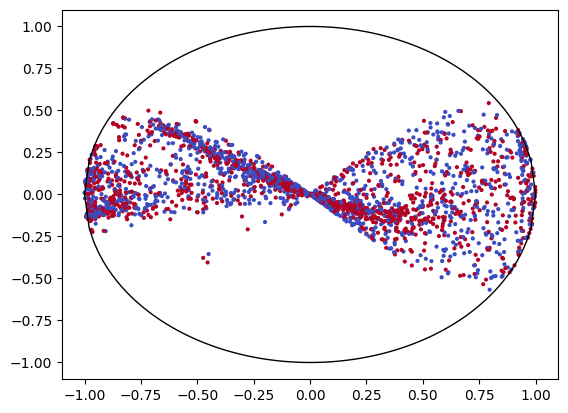

In [7]:
# Plot Klein embeddings
plt.scatter(X_klein[:, 0], X_klein[:, 1], c=y_hyp, cmap="coolwarm", s=4)

# Plot unit circle
x = np.linspace(-1, 1, 100)
y = np.sqrt(1 - x ** 2)
plt.plot(x, y, c="k", linewidth=1)
plt.plot(x, -y, c="k", linewidth=1)


In [8]:
# Check that hyperboloid is actually a hyperboloid

assert np.allclose(np.sum(X_hyp[:, :-1] ** 2, axis=1) - X_hyp[:, -1] ** 2, -1)
assert np.all(X_hyp[:, -1] >= 1)
assert np.all(X_hyp[:, -1] > np.linalg.norm(X_hyp[:, :-1], axis=1))


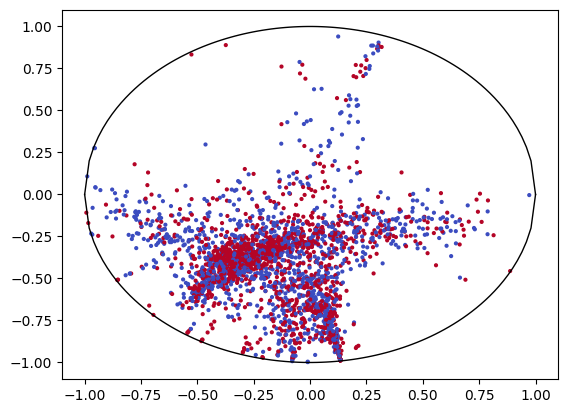

In [9]:
# For reference, plot Poincare embeddings

plt.scatter(X_poi[:, 0], X_poi[:, 1], c=y_poi, cmap="coolwarm", s=4)

# Plot unit circle
x = np.linspace(-1, 1, 100)
y = np.sqrt(1 - x ** 2)
plt.plot(x, y, c="k", linewidth=1)
plt.plot(x, -y, c="k", linewidth=1)


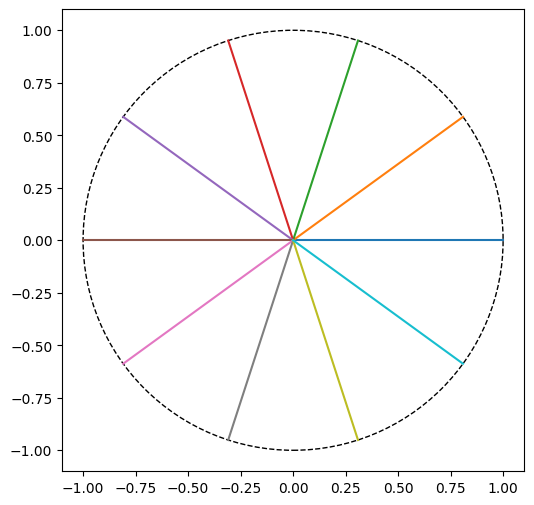

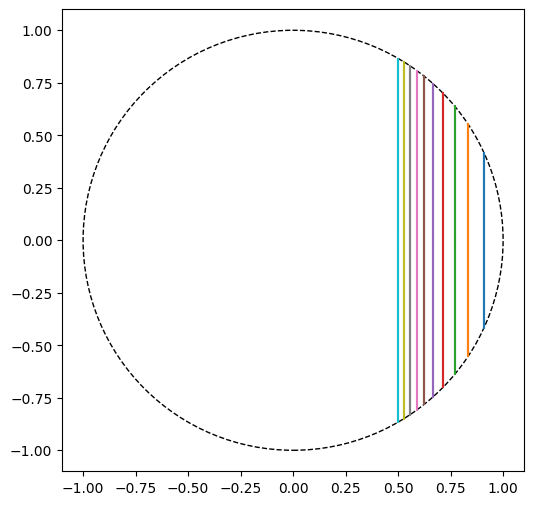

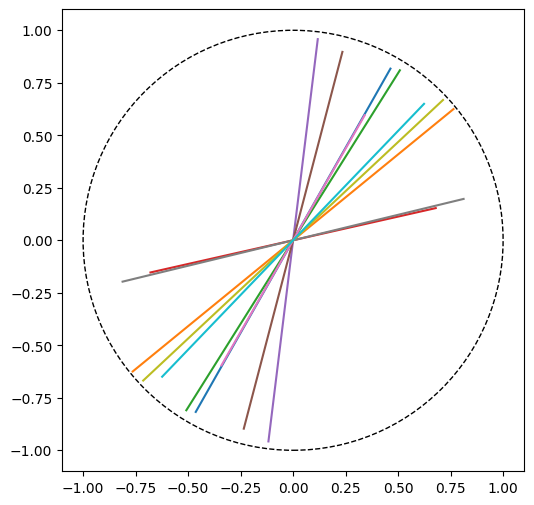

In [10]:
# Verify that geodesics in Poincare map to straight lines in Klein - ChatGPT
# Yes, this works!


def draw_poincare_disk():
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.add_artist(
        plt.Circle((0, 0), 1, fill=False, color="black", linestyle="dashed")
    )
    ax.set_aspect("equal", "box")
    return ax


def kleinify(x, y):
    X = np.stack((x, y), axis=1)
    X = convert(X, initial="poincare", final="klein")
    x = X[:, 0]
    y = X[:, 1]
    return x, y


def radial_geodesics(n=10, klein=False):
    ax = draw_poincare_disk()
    thetas = np.linspace(0, 2 * np.pi, n, endpoint=False)
    for theta in thetas:
        t = np.linspace(
            0, 0.999, 100
        )  # Stopping at 0.999 to keep inside the disk
        x = t * np.cos(theta)
        y = t * np.sin(theta)
        x, y = kleinify(x, y) if klein else (x, y)
        ax.plot(x, y)
    plt.show()


def circular_geodesics(n=10, klein=False):
    ax = draw_poincare_disk()
    centers = np.linspace(1.1, 2, n)  # Starting at 1.1 to be outside the disk
    for c in centers:
        r = np.sqrt(c ** 2 - 1)
        theta = np.linspace(0, 2 * np.pi, 100)
        x = r * np.cos(theta) + c
        y = r * np.sin(theta)
        x, y = kleinify(x, y) if klein else (x, y)
        ax.plot(x, y)
    plt.show()


def diametrical_geodesics(n=10, klein=False):
    ax = draw_poincare_disk()
    points = np.random.rand(n, 2) * 0.8  # Random points inside the disk
    for p in points:
        x = [p[0], -p[0]]
        y = [p[1], -p[1]]
        x, y = kleinify(x, y) if klein else (x, y)
        ax.plot(x, y)
    plt.show()


radial_geodesics(klein=True)
circular_geodesics(klein=True)
diametrical_geodesics(klein=True)


In [11]:
# Compare hdt to dt+Klein

args = {"max_depth": 20}

hdt = HyperbolicDecisionTreeClassifier(timelike_dim=-1, **args)
hdt.fit(X_hyp, y_hyp)
hdt_score = hdt.score(X_hyp, y_hyp)

kdt = DecisionTreeClassifier(**args)
kdt.fit(X_klein, y_hyp)
kleindt_score = kdt.score(X_klein, y_hyp)

print(f"HDT score: {hdt_score}")
print(f"Klein DT score: {kleindt_score}")

# Ok wow... this is a huge difference!


[False False False ... False False False] [ True  True  True ...  True  True  True]
[False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False  True False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False  True
 False  True False False False False False False False  True False False
 False False False False False False False False False False  True False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False Fal

KeyboardInterrupt: 

In [ ]:
# Let's quickly check the IBD data

X_ibd, y_ibd = make_anndata_X_y(
    column="ibd", embedding="hyp_mix_128", balance=True, seed=42, adata=adata
)
X_ibd_klein = hyperboloid_to_klein(X_ibd, timelike_dim=-1)

# Sanity check: everything is inside unit circle
assert np.all(np.linalg.norm(X_ibd_klein, axis=1) <= 1)


In [ ]:
# kdt on IBD data
from sklearn.model_selection import train_test_split

X_ibd_klein_train, X_ibd_klein_test, y_train, y_test = train_test_split(
    X_ibd_klein, y_ibd, test_size=0.2, random_state=42
)

kdt_ibd = DecisionTreeClassifier(max_depth=4)

kdt_ibd.fit(X_ibd_klein_train, y_train)

kdt_ibd_score = kdt_ibd.score(X_ibd_klein_test, y_test)
print(f"KDT IBD score: {kdt_ibd_score}")


KDT IBD score: 0.550185873605948


In [ ]:
# Does it beat PCA?
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_ibd_pca, y_ibd = make_anndata_X_y(
    adata,
    column="ibd",
    balance=True,
    embedding=None,
    seed=42,
    to_dense=True,
)

X_ibd_pca_train, X_ibd_pca_test, y_ibd_train, y_ibd_test = train_test_split(
    X_ibd_pca, y_ibd, test_size=0.2, random_state=42
)

pca = PCA(n_components=128)

pca.fit(X_ibd_pca_train)

X_ibd_pca_train = pca.transform(X_ibd_pca_train)
X_ibd_pca_test = pca.transform(X_ibd_pca_test)

# Train dt
pca_dt = DecisionTreeClassifier(random_state=42, max_depth=4)
pca_dt.fit(X_ibd_pca_train, y_ibd_train)

# Test dt
pca_dt_score = pca_dt.score(X_ibd_pca_test, y_ibd_test)
print(f"PCA Decision Tree Score: {pca_dt_score}")

# No, PCA seems to do a little bit better...


KeyboardInterrupt: 

In [ ]:
# Code to convert Poincare to Klein:


def poincare_to_klein(X):
    """Convert Poincare ball coordinates to Klein coordinates."""
    return 2 * X / (1 + np.linalg.norm(X, axis=1) ** 2)[:, None]


In [133]:
# What if we did a simpler, more hyperbolic classification task?

otu_embeddings_poi = adata.varm["component_embeddings_poincare_4"]
classes = adata.var["taxonomy_1"]
classes_keep = classes.isin(
    [
        "p__Firmicutes",
        "p__Proteobacteria",
        "p__Bacteroidetes",
        "p__Actinobacteria",
        "p__Acidobacteria",
        "p__Planctomycetes",
    ]
)
classes = classes.loc[classes_keep]
otu_embeddings_poi = otu_embeddings_poi.loc[classes_keep]

# Sample a random 1000 OTUs
np.random.seed(42)
sample = np.random.choice(otu_embeddings_poi.index, 1000, replace=False)
otu_embeddings_poi = otu_embeddings_poi.loc[sample]
classes = classes.loc[sample]


In [215]:
from sklearn.model_selection import train_test_split

# Convert classes to integers
y = np.zeros(len(classes), dtype=int)
for i, x in enumerate(classes.unique()):
    y[classes == x] = i

# Get X and y matrices from this
X_train_otu_poi, X_test_otu_poi, y_train, y_test = train_test_split(
    otu_embeddings_poi, y, test_size=0.2, random_state=42
)
X_train_otu_hyp = convert(
    X_train_otu_poi, "poincare", "hyperboloid", timelike_dim=-1
)
X_test_otu_hyp = convert(
    X_test_otu_poi, "poincare", "hyperboloid", timelike_dim=-1
)
X_train_otu_klein = convert(X_train_otu_poi, "poincare", "klein")
X_test_otu_klein = convert(X_test_otu_poi, "poincare", "klein")

# Initialize models
MAX_DEPTH = 10
dt1 = DecisionTreeClassifier(max_depth=MAX_DEPTH)
dt2 = DecisionTreeClassifier(max_depth=MAX_DEPTH)
dt3 = DecisionTreeClassifier(max_depth=MAX_DEPTH)
dt4 = HyperbolicDecisionTreeClassifier(
    max_depth=MAX_DEPTH, timelike_dim=0
)  # timelike is 0 since we use convert()
dt5 = EuclideanDecisionTreeClassifier(max_depth=MAX_DEPTH)

# Fit
dt1.fit(X_train_otu_poi, y_train)  # DT + Poincare
dt2.fit(X_train_otu_klein, y_train)  # DT + Klein
dt3.fit(X_train_otu_hyp, y_train)  # DT + Hyperboloid
dt4.fit(X_train_otu_hyp, y_train)  # HDT + Hyperboloid
dt5.fit(X_train_otu_hyp, y_train)  # HDT control - should approximate dt3

# Scores
dt1_score = dt1.score(X_test_otu_poi, y_test)
dt2_score = dt2.score(X_test_otu_klein, y_test)
dt3_score = dt3.score(X_test_otu_hyp, y_test)
dt4_score = dt4.score(X_test_otu_hyp, y_test)
dt5_score = dt5.score(X_test_otu_hyp, y_test)

# Print
print(f"DT + Poincare: {dt1_score}")
print(f"DT + Klein: {dt2_score}")
print(f"DT + Hyperboloid: {dt3_score}")
print(f"HDT + Hyperboloid: {dt4_score}")
print(f"HDT control: {dt5_score}")


DT + Poincare: 0.89
DT + Klein: 0.885
DT + Hyperboloid: 0.88
HDT + Hyperboloid: 0.9
HDT control: 0.885


In [146]:
_l, _r = dt5._get_split(X_train_otu_hyp, 2, np.median(X_train_otu_hyp[:, 2]))
dt5._information_gain(_l, _r, y_train)


0.12086874999999997

In [122]:
dt5._get_candidates(X_train_otu_hyp, 4)


array([-49.17405436, -45.88525555, -43.69029742, -35.11486578,
       -17.76047412,  -6.01378979,  -2.3637744 ,   0.95174765,
         2.54204555,   3.321359  ,   3.40914756,   3.54068093,
         3.63632916,   3.70110892,   3.76625537,   4.39694758,
         5.15114134,   5.40864416,   5.58861794,   5.75922057,
         5.90868414,   6.11062904,   6.32012634,   6.39291936,
         6.41040518,   6.50792148,   6.60857208,   6.81539449,
         7.16058147,   7.3560962 ,   7.41037465,   7.55769144,
         7.71037694,   7.84517087,   7.99580247,   8.0302856 ,
         8.05385802,   8.15366847,   8.30196426,   8.4164603 ,
         8.51283726,   8.68374653,   8.81980049,   8.87995016,
         8.94867322,   8.98978681,   9.03464047,   9.07312905,
         9.1160705 ,   9.25641695,   9.44495016,   9.53900489,
         9.60578612,   9.66828994,   9.69581075,   9.88556237,
        10.07579804,  10.09489744,  10.17394125,  10.27657073,
        10.33011961,  10.3873259 ,  10.46141059,  10.51

In [124]:
dt5._leaf_values(y_train[_l])


(0, array([0.535, 0.465]))

In [125]:
dt5._leaf_values(y_train)


(1, array([0.495, 0.505]))

In [120]:
# Make sure that _left works correctly
_dim0 = dt5.tree.feature
_theta0 = dt5.tree.theta
_left0 = dt5.tree.left

_l0, _r0 = dt5._get_split(X_train_otu_hyp, _dim0, _theta0)

print(np.all([dt5._left(x, dt5.tree) for x in X_train_otu_hyp[_l0]]))  # True
print(
    np.all([not dt5._left(x, dt5.tree) for x in X_train_otu_hyp[_r0]])
)  # True


True
True


In [170]:
len(dt5.tree.data)


800

In [171]:
len(dt5.tree.left.data)


467

In [172]:
len(dt5.tree.right.data)


333

In [173]:
len(dt5.tree.left.left.data)


352

In [174]:
len(dt5.tree.left.right.data)


115

In [181]:
dt5.tree.left.right.data.shape


(115, 5)

In [188]:
dt5._leaf_values(dt5.tree.left.right.y)


(1,
 array([0.00869565, 0.99130435, 0.        , 0.        , 0.        ,
        0.        ]))

In [193]:
dt5._leaf_values(dt5.tree.left.right.left.y)


(1,
 array([0.33333333, 0.66666667, 0.        , 0.        , 0.        ,
        0.        ]))

In [207]:
dt5.tree.left.right.left.left.y


array([2, 2])

In [205]:
dt5.tree.left.right.left.right.y


array([0])

In [209]:
dt5._leaf_values(dt5.tree.left.right.left.left.y)


(0, array([1., 0., 0., 0., 0., 0.]))

In [212]:
dt5._get_probs(dt5.tree.left.right.left.left.y)


array([1., 0., 0., 0., 0., 0.])

In [213]:
my_y = dt5.tree.left.right.left.left.y
_, inverse_y = np.unique(my_y, return_inverse=True)  # (0, ..., N-1)


In [214]:
inverse_y


array([0, 0])